In [1]:
import os
import os.path
import pickle

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
NOTE = '全特徴量を使用したSVM. class_weight は指定しない。Cは1.0'

N = 5
CV = f'Stratified-Kfold(K={N})'

notebook_name = '009_SVM_NOTbalanced_C1'
OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1
CATEGORICAL_FEATURES =  [
        'batterID', 'pitcherID', 'Match',
        'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher',
        'isBottom', 'batterTeam', 'pitcherTeam'
    ]

009_submission.csv 009_SVM_NOTbalanced_C1


In [3]:
def get_estimator(categorical_features, discrete_features):
    discrete_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('discrete', discrete_transformer, discrete_features),
            ('categorical', 'passthrough', categorical_features),
        ]
    )
    return Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('estimator', SVC(C=1.0, random_state=SEED))
        ]
    )

In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
for c in CATEGORICAL_FEATURES:
    assert(train[c].isin(test[c]).sum() == train.shape[0])
    assert(test[c].isin(train[c]).sum() == test.shape[0])

train = pd.get_dummies(train, columns=CATEGORICAL_FEATURES, drop_first=True)
test = pd.get_dummies(test, columns=CATEGORICAL_FEATURES, drop_first=True)

assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

In [6]:
categorical_features = []
for c in CATEGORICAL_FEATURES:
    categorical_features += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
categorical_features

['batterID_0',
 'batterID_2',
 'batterID_5',
 'batterID_9',
 'batterID_11',
 'batterID_12',
 'batterID_15',
 'batterID_18',
 'batterID_19',
 'batterID_21',
 'batterID_22',
 'batterID_26',
 'batterID_27',
 'batterID_28',
 'batterID_29',
 'batterID_31',
 'batterID_34',
 'batterID_36',
 'batterID_37',
 'batterID_39',
 'batterID_42',
 'batterID_45',
 'batterID_47',
 'batterID_50',
 'batterID_55',
 'batterID_56',
 'batterID_58',
 'batterID_60',
 'batterID_67',
 'batterID_70',
 'batterID_72',
 'batterID_73',
 'batterID_75',
 'batterID_80',
 'batterID_82',
 'batterID_84',
 'batterID_85',
 'batterID_87',
 'batterID_89',
 'batterID_91',
 'batterID_98',
 'batterID_102',
 'batterID_103',
 'batterID_105',
 'batterID_106',
 'batterID_111',
 'batterID_112',
 'batterID_114',
 'batterID_117',
 'batterID_118',
 'batterID_120',
 'batterID_121',
 'batterID_125',
 'batterID_127',
 'batterID_128',
 'batterID_130',
 'batterID_132',
 'batterID_134',
 'batterID_135',
 'batterID_137',
 'batterID_138',
 'batter

In [7]:
features = [c for c in train.columns if c not in ('id', 'y')]
assert(set(features) - set(test.columns.tolist()) == set())

In [8]:
discrete_features = [f for f in features if f not in categorical_features]
discrete_features

['totalPitchingCount',
 'B',
 'S',
 'O',
 'b1',
 'b2',
 'b3',
 'inningNo',
 'numRunners',
 'pitcherHoursElapsed',
 'pitcherNumGamesParticipated',
 'batterHoursElapsed',
 'batterNumGamesParticipated',
 'ballPositionLabel__no_data__',
 'ど真ん中',
 '内角中心',
 '内角低め',
 '内角高め',
 '外角中心',
 '外角低め',
 '外角高め',
 '真ん中低め',
 '真ん中高め',
 'ballPositionLabeld1',
 'ballPositionLabeld2',
 'ballPositionLabeld3',
 'ballPositionLabeld4',
 'ballPositionLabeld5',
 'ballPositionLabeld6',
 'ballPositionLabeld7',
 'ballPositionLabeld8',
 'ballPositionLabeld9',
 'ballPositionLabeld10',
 'ballPositionLabeld11',
 'ballPositionLabeld12',
 'ballPositionLabeld13',
 'ballPositionLabeld14',
 'ballPositionLabeld15',
 'ballPositionLabeld16',
 'ballPositionLabeld17',
 'ballPositionLabeld18',
 'ballPositionLabeld19',
 'ballPositionLabeld20',
 'ballPositionLabeld21',
 'ballPositionLabeld22',
 'ballPositionLabeld23',
 'ballPositionLabeld24',
 'ballPositionLabeld25',
 'ballPositionLabeld26',
 'ballPositionLabeld27',
 'ballPositionLabe

In [9]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )
    clf = get_estimator(categorical_features, discrete_features)
    clf.fit(X_train, y_train)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



**********Confusion matrix for train set (Fold 1)**********
[[4343  533  177   13    0    0    0    0]
 [1555 2023  125   43    0    0    0    0]
 [1241  419  680   53    0    0    0    0]
 [ 763  191  154  601    0    0    0    0]
 [ 312  118   43   60    7    0    0    0]
 [  93   22    7   28    0    0    0    0]
 [   4    4    0    0    0    0    0    0]
 [  59   18    4   15    0    0    0    0]]

**********Confusion matrix for validation set (Fold 1)**********
[[856 271 107  33   0   0   0   0]
 [570 273  67  26   0   0   0   0]
 [385 119  75  20   0   0   0   0]
 [245  84  35  63   0   0   0   0]
 [ 83  21  14  17   0   0   0   0]
 [ 24   7   1   5   0   0   0   0]
 [  1   2   0   0   0   0   0   0]
 [ 18   2   3   1   0   0   0   0]]

**********Confusion matrix for train set (Fold 2)**********
[[4370  480  198   18    0    0    0    0]
 [1562 1996  156   32    0    0    0    0]
 [1190  422  738   43    0    0    0    0]
 [ 770  221  152  566    0    0    0    0]
 [ 303  111   4

In [10]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.261876,0.146291
std,0.004269,0.004896
min,0.255257,0.140236
25%,0.261117,0.141712
50%,0.262525,0.149258
75%,0.263590,0.149925
max,0.266892,0.150323


In [11]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,0,0,1
1,1,1,0,0,1
2,2,0,0,0,1
3,3,2,0,0,1
4,4,4,0,0,1
...,...,...,...,...,...
17126,9690,0,2,0,5
17129,9693,1,2,0,5
17130,16833,1,1,0,5
17133,9762,1,2,0,5


In [12]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,5.243370,6.275566,4.204651,7.282161,2.956872,1.741805,-0.291930,0.734087,27446,1
1,6.271801,6.276715,4.218311,6.280472,2.847405,1.734050,-0.292508,0.726701,113,1
2,6.290544,7.297555,5.211843,4.201649,2.773435,1.728000,-0.292644,0.725845,4479,1
3,6.290432,7.295703,5.215037,4.219838,2.775394,1.727359,-0.292701,0.725970,29080,1
4,7.291152,6.276239,4.227321,5.250358,2.830202,1.745596,-0.292813,0.718633,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,5.227566,6.296321,3.904813,7.291094,3.103401,1.779978,-0.293845,0.704910,24272,5
33804,5.133569,3.842680,2.773004,7.310912,6.219477,1.795915,-0.293075,0.726452,29106,5
33805,5.012128,3.805861,2.781145,7.311966,6.212953,1.804120,-0.293115,0.728539,20679,5
33806,6.286375,5.031386,3.757531,7.303342,3.159752,1.767815,-0.293071,0.722277,25901,5


In [13]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,31.438968,36.485555,24.157044,23.097643,13.963630,8.774248,-1.472479,3.548378
1,1,34.438861,33.445441,23.025235,24.235557,13.852084,8.762885,-1.468190,3.614334
2,2,20.722383,29.021975,28.040919,36.486931,15.968040,8.757600,-1.461970,3.687495
3,3,30.379575,28.378932,16.916714,35.456157,17.831504,8.730869,-1.467840,3.596796
4,4,31.469883,36.488734,22.757983,23.958488,13.902114,8.721913,-1.462348,3.580057
...,...,...,...,...,...,...,...,...,...
33803,33803,36.497461,31.341818,23.804891,22.924760,14.461364,8.713313,-1.468018,3.665822
33804,33804,26.392219,31.426212,18.817930,36.467815,14.321285,8.741921,-1.473214,3.637857
33805,33805,36.434518,27.390532,18.795524,30.405301,14.522777,5.690708,-1.462395,6.792184
33806,33806,24.141768,31.316451,23.157708,36.417508,15.639251,9.115457,-1.462442,3.563643


In [14]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,0
2,2,3
3,3,3
4,4,1
...,...,...
33803,33803,0
33804,33804,3
33805,33805,0
33806,33806,3


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.377337
1    0.252159
2    0.000059
3    0.370445
Name: y, dtype: float64

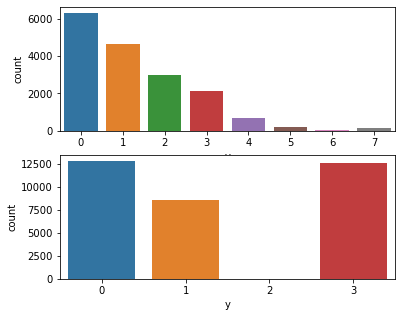

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [16]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [17]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.2618762775643101, 0.1462908027731545)

In [18]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"009_submission.csv","Stratified-Kfold(K=5)","0.261876","0.146291","","全特徴量を使用したSVM. class_weight は指定しない。Cは1.0"


In [19]:
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()